# The DeepSensor package

*WIP Intro text*

DeepSensor is a Python package for modelling environmental data with convolutional neural process (ConvNP) models.
All you need to get started is your `pandas` and `xarray` data.

For the environmental ConvNP modelling pipeline, DeepSensor aims to:
- massively lower the barrier to entry for non-experts,
- automate away the frustrating details for experts,
- allow flexibility when needed,
- foster a community of users and contributors,
- accelerate scientific and technical progress through open-source software.

They key contribution of DeepSensor is the provision of classes for data processing, task loading, inference, and active learning.
DeepSensor wraps around `neuralprocesses`, an NP library, for the core modelling functionality.

The `deepsensor` interface sits at a fairly high level of abstraction, allowing you to stay almost entirely in the familiar world of `pandas` and `xarray`, avoiding the murky depths of tensors (*"what was the shape meant to be?! what is the batch dimension?!"*).

This notebook demonstrates an end-to-end modelling pipeline using `deepsensor` functionality.

## Imports/set-up

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

You must import either the `torch` or `tensorflow` extensions of deepsensor before other deepsensor modules. This ensures `deepsensor` has access to the deep learning library backend.


In [2]:
# import deepsensor.torch as deepsensor
import deepsensor.tensorflow as deepsensor

2023-06-11 18:56:31.429132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 18:56:31.556909: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from deepsensor.data.processor import DataProcessor
from deepsensor.data.loader import TaskLoader
from deepsensor.model.models import ConvNP

from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.utils import construct_x1x2_ds, construct_circ_time_ds
from deepsensor.model.nps import compute_encoding_tensor
from deepsensor.data.utils import concat_tasks

We'll also make use of some other packages in our pipeline

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import dask
import json

import lab as B

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
sns.set_style("white")

from pprint import pprint
from tqdm.notebook import tqdm

In [5]:
# Run on GPU if available by setting GPU as default device
set_gpu_default_device()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2023-06-11 18:56:52.508919: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 13163 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:98:00.0, compute capability: 8.6
2023-06-11 18:56:52.671112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13163 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:98:00.0, compute capability: 8.6


In [6]:
# Plot stuff
extent = [-3.5e6, 3.5e6, -3.5e6, 3.5e6]
crs = ccrs.LambertAzimuthalEqualArea(0, -90)

## Load your data!

In [7]:
# era5_ds = xr.open_mfdataset('../deepsensor_old/data/antarctica/gridded/processed/*/*.nc')
era5_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/gridded/interim/tas_anom/*.nc')
era5_raw_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    t2m        (time, y, x) float32 dask.array<chunksize=(365, 280, 280), meta=np.ndarray>

In [8]:
aux_raw_ds = xr.open_mfdataset('../../deepsensor_old/data/antarctica/auxiliary/interim/*25000m/*.nc')
aux_raw_ds = aux_raw_ds[['surface', 'mask']]
aux_raw_ds

<xarray.Dataset>
Dimensions:  (y: 280, x: 280)
Coordinates:
  * y        (y) float64 3.488e+06 3.462e+06 3.438e+06 ... -3.462e+06 -3.488e+06
  * x        (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    lat      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    surface  (y, x) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    mask     (y, x) float64 dask.array<chunksize=(280, 280), meta=np.ndarray>
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [9]:
station_raw_df = pd.read_csv('../../deepsensor_old/data/antarctica/station/interim/XY_station.csv')
station_raw_df = station_raw_df.rename(columns={'date': 'time'})
station_raw_df['time'] = pd.to_datetime(station_raw_df['time'])
station_raw_df = station_raw_df.set_index(['station', 'time', 'y', 'x']).sort_index()[['tas']]
station_raw_df

tas
station                    time       y             x                      
A028_a_new                 1986-02-19 -9.065425e+05 2.219200e+06 -14.800000
                           1986-02-22 -9.065425e+05 2.219200e+06 -12.333333
                           1986-02-24 -9.065425e+05 2.219200e+06 -15.926087
                           1986-02-26 -9.065425e+05 2.219200e+06 -12.981250
                           1986-02-27 -9.065425e+05 2.219200e+06 -11.900000
...                                                                     ...
Zoraida(Priestley Glacier) 2020-01-01 -1.683977e+06 5.187024e+05  -5.925000
                           2020-01-02 -1.683977e+06 5.187024e+05  -4.066667
                           2020-01-03 -1.683977e+06 5.187024e+05  -3.941667
                           2020-01-04 -1.683977e+06 5.187024e+05  -5.670833
                           2020-01-05 -1.683977e+06 5.187024e+05  -6.433333

[941850 rows x 1 columns]

## Data processing

We will now normalise data (either to have zero mean and unit variance or lie in [-1, 1]), and standardise the spatial coordinates to be in the range [0, 1].

TODO
- Note on variable IDs inferred from data names here?

### Normalise data with DataProcessor

When instantiating a `DataProcessor` object, specify the names of the spatial coordinates and their raw values to normalise to 0 and 1.

In [10]:
data_processor = DataProcessor(
    x1_name='y', x1_map=(0, 3.5e6),
    x2_name='x', x2_map=(0, 3.5e6),
    verbose=True,
)

In [11]:
era5_ds, station_df = data_processor([era5_raw_ds, station_raw_df])
aux_ds = data_processor(aux_raw_ds, method="min_max")

Normalisation params for t2m not computed. Computing now... Done. t2m mean=0.050, std=3.834
Normalisation params for tas not computed. Computing now... Done. tas mean=-16.262, std=14.696
Normalisation params for surface not computed. Computing now... Done. surface min=0.000, max=4047.722
Normalisation params for mask not computed. Computing now... Done. mask min=0.000, max=1.000


In [12]:
pprint(data_processor.norm_params)

{'coords': {'time': {'name': 'time'},
            'x1': {'map': (0.0, 3500000.0), 'name': 'y'},
            'x2': {'map': (0.0, 3500000.0), 'name': 'x'}},
 'mask': {'max': 1.0, 'min': 0.0},
 'surface': {'max': 4047.721923828125, 'min': 0.0},
 't2m': {'mean': 0.05024006962776184, 'std': 3.8340163230895996},
 'tas': {'mean': -16.261720883718517, 'std': 14.695655954303943}}


The normalised data now has standardised `x1` and `x2` coordinates, and the data has been normalised to have zero mean and unit variance.

In [13]:
era5_ds

<xarray.Dataset>
Dimensions:    (time: 25933, x1: 280, x2: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * x1         (x1) float64 0.9964 0.9893 0.9821 ... -0.9821 -0.9893 -0.9964
  * x2         (x2) float64 -0.9964 -0.9893 -0.9821 ... 0.9821 0.9893 0.9964
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    t2m        (time, x1, x2) float32 -0.1377 -0.1358 -0.131 ... 0.05715 0.0261

In [14]:
aux_ds

<xarray.Dataset>
Dimensions:  (x1: 280, x2: 280)
Coordinates:
  * x1       (x1) float64 0.9964 0.9893 0.9821 0.975 ... -0.9821 -0.9893 -0.9964
  * x2       (x2) float64 -0.9964 -0.9893 -0.9821 ... 0.9821 0.9893 0.9964
    lat      (x1, x2) float32 -44.58 -44.76 -44.93 ... -44.93 -44.76 -44.58
    lon      (x1, x2) float32 -45.0 -44.79 -44.59 -44.38 ... 135.4 135.2 135.0
Data variables:
    surface  (x1, x2) float32 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    mask     (x1, x2) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
Attributes: (12/19)
    Author:                      Mathieu Morlighem
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    Projection:                  Polar Stereographic South (71S,0E)
    Title:                       BedMachine Antarctica
    ice_density (kg m-3):        917.0
    ...                          ...
    spacing:                     500
    valid_range:                 [0. 4.]
    version:                     15-Jul-2020 (v2.0)
    xmin:                        -3333000
    ymax:                        3333000
    Conventions:                 CF-1.7

In [15]:
station_df

tas
station                    time       x1        x2                
A028_a_new                 1986-02-19 -0.259012 0.634057  0.099466
                           1986-02-22 -0.259012 0.634057  0.267316
                           1986-02-24 -0.259012 0.634057  0.022839
                           1986-02-26 -0.259012 0.634057  0.223227
                           1986-02-27 -0.259012 0.634057  0.296803
...                                                            ...
Zoraida(Priestley Glacier) 2020-01-01 -0.481136 0.148201  0.703386
                           2020-01-02 -0.481136 0.148201  0.829841
                           2020-01-03 -0.481136 0.148201  0.838347
                           2020-01-04 -0.481136 0.148201  0.720682
                           2020-01-05 -0.481136 0.148201  0.668795

[941850 rows x 1 columns]

### Saving normalisation parameters for later
A `DataProcessor` object can be initialised with pre-computed normalisation parameters.

In [16]:
with open('norm_params.json', 'w') as f:
    json.dump(data_processor.norm_params, f)

In [17]:
norm_params = json.load(open('norm_params.json', 'r'))
data_processor = DataProcessor(norm_params)
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': [0.0, 3500000.0], 'name': 'y'},
            'x2': {'map': [0.0, 3500000.0], 'name': 'x'}},
 'mask': {'max': 1.0, 'min': 0.0},
 'surface': {'max': 4047.721923828125, 'min': 0.0},
 't2m': {'mean': 0.05024006962776184, 'std': 3.8340163230895996},
 'tas': {'mean': -16.261720883718517, 'std': 14.695655954303943}}


### Aside: Unnormalisation with the DataProcessor
This will be useful when it comes to mapping model predictions back from normalised space to raw data space.

In [18]:
era5_unnorm_ds, station_unnorm_df = data_processor.unnormalise([era5_ds, station_df])
aux_unnorm_ds = data_processor.unnormalise(aux_ds, method="min_max")

The normalised data has been mapped back to the raw data values (including coordinates):

In [19]:
era5_unnorm_ds

<xarray.Dataset>
Dimensions:    (time: 25933, y: 280, x: 280)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2020-12-31
  * y          (y) float64 3.488e+06 3.462e+06 ... -3.462e+06 -3.488e+06
  * x          (x) float64 -3.488e+06 -3.462e+06 ... 3.462e+06 3.488e+06
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Data variables:
    t2m        (time, y, x) float32 -0.4777 -0.4703 -0.4519 ... 0.2694 0.1503

In [20]:
station_unnorm_df

tas
station                    time       y             x                      
A028_a_new                 1986-02-19 -9.065425e+05 2.219200e+06 -14.800000
                           1986-02-22 -9.065425e+05 2.219200e+06 -12.333333
                           1986-02-24 -9.065425e+05 2.219200e+06 -15.926087
                           1986-02-26 -9.065425e+05 2.219200e+06 -12.981250
                           1986-02-27 -9.065425e+05 2.219200e+06 -11.900000
...                                                                     ...
Zoraida(Priestley Glacier) 2020-01-01 -1.683977e+06 5.187024e+05  -5.925000
                           2020-01-02 -1.683977e+06 5.187024e+05  -4.066667
                           2020-01-03 -1.683977e+06 5.187024e+05  -3.941667
                           2020-01-04 -1.683977e+06 5.187024e+05  -5.670833
                           2020-01-05 -1.683977e+06 5.187024e+05  -6.433333

[941850 rows x 1 columns]

### Add extra auxiliary information
Adding coordinate fields helps with learning spatial non-stationarity, and adding time fields helps with learning temporal non-stationarity.

In [21]:
x1x2_ds = construct_x1x2_ds(aux_ds)
aux_ds['x1_arr'] = x1x2_ds['x1_arr']
aux_ds['x2_arr'] = x1x2_ds['x2_arr']

dates = pd.date_range(era5_ds.time.values.min(), era5_ds.time.values.max(), freq="D")
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = doy_ds["cos_D"]
aux_ds["sin_D"] = doy_ds["sin_D"]

## Loading tasks

### Set up a TaskLoader object
Note the flexibility of the `TaskLoader` init arguments below.
With slight changes to the arguments, we can instantiate a `TaskLoader` that generates tasks for forecasting or interpolation.

In [22]:
task_loader = TaskLoader(context=[era5_ds['t2m'], aux_ds], target=era5_ds['t2m'],
                         context_delta_t=0, target_delta_t=0,)
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('t2m',), ('surface', 'mask', 'x1_arr', 'x2_arr', 'cos_D', 'sin_D'))
Target variable IDs: (('t2m',),)


In [23]:
# task_loader.load_dask()  # Load any dask arrays into memory for faster training

### The TaskLoader outputs Tasks, which are dict-like objects containing context and target data

Calling a `TaskLoader` with a `date` generates a `Task` for that date by slicing the context and target variables.
`Task`s inherit from `dict` and provide `__str__` and `__repr__` methods for debugging.
`TaskLoader` offers several data sampling methods for generating `Task`s.
```
"all": sample all observations (i.e. all grid cells for gridded xarray data)
N, int: uniform random sampling of N observations (i.e. grid cells for gridded xarray data)
```

In [24]:
task = task_loader("2000-01-01", "all", 10)
print(type(task), "\n")

print("Concise task summary:")
print(task)

print("Verbose task summary:")
print(repr(task))

<class 'deepsensor.data.task.Task'> 

Concise task summary:
time: 2000-01-01 00:00:00
flag: None
X_c: [((1, 280), (1, 280)), ((1, 280), (1, 280))]
Y_c: [(1, 280, 280), (6, 280, 280)]
X_t: [(2, 10)]
Y_t: [(1, 10)]

Verbose task summary:
time: Timestamp/2000-01-01 00:00:00
flag: NoneType/None
X_c: [('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)'), ('ndarray/float32/(1, 280)', 'ndarray/float32/(1, 280)')]
Y_c: ['ndarray/float32/(1, 280, 280)', 'ndarray/float32/(6, 280, 280)']
X_t: ['ndarray/float32/(2, 10)']
Y_t: ['ndarray/float32/(1, 10)']



## Initialise model

### Set up ConvNP object

`ConvNP` wraps around the `neuralprocesses` library to provide a convenient interface for inference with environmental data in the form of `Task`s.

There are several ways to set up a `ConvNP` object.

Advanced users can instantiate a ConvNP from an existing `neuralprocesses` model working in pure `neuralprocesses` for more flexibility.


In [25]:
custom_model = deepsensor.backend.nps.construct_convgnp()
model = ConvNP(data_processor, task_loader, custom_model)

However, we will instantiate a ConvNP with a TaskLoader to infer sensible defaults (unless overridden with `neuralprocesses.construct_convgnp` kwargs).
The TaskLoader and DataProcessor will also be used to unnormalise model predictions at inference time.


In [26]:
model_dim = 30
model = ConvNP(data_processor, task_loader, unet_channels=(model_dim,) * 4, likelihood="het")

dim_yc inferred from TaskLoader: (1, 6)
dim_yt inferred from TaskLoader: 1
points_per_unit inferred from TaskLoader: 167
encoder_scales inferred from TaskLoader: [0.0035714285913854837, 0.0035714285913854837]


A `ConvNP`'s `__call__` method accepts a `Task` and returns a distribution object.
The distribution object can be used to compute predictions, sample from the model, compute entropy, etc, without having to run the model again.

In [27]:
# Run model on a random task to build model, with all context data and 3 random target locations
task = task_loader("2000-01-01", "all", 3)
task = ConvNP.modify_task(task)

dist = model(task)
print('Distribution object: ', type(dist))
x = model.mean(dist)
print('Mean: ', x.shape, x)
x = model.sample(dist, n_samples=2)
print('Sample: ', x.shape, x)
x = model.variance(dist)
print('Variance: ', x.shape, x)
x = model.stddev(dist)
print('Std dev: ', x.shape, x)
x = model.covariance(dist)
print('Covariance: ', x.shape)
x = model.logpdf(dist, task)
print('logpdf: ', x)
x = model.entropy(dist)
print('Entropy: ', x)

2023-06-11 18:57:47.964071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-11 18:57:57.610442: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201


Distribution object:  <class 'neuralprocesses.dist.normal.MultiOutputNormal[matrix.matrix.Dense, matrix.constant.Zero, matrix.diagonal.Diagonal]'>
Mean:  (1, 3) [[-1.7121264 -4.8059816  2.2536278]]
Sample:  (2, 1, 3) [[[-1.7121264 -4.8059816  2.2536278]]

 [[-1.7121264 -4.8059816  2.2536278]]]
Variance:  (1, 3) [[5.6343627 7.4898057 7.9371223]]
Std dev:  (1, 3) [[2.3736813 2.7367508 2.8172898]]
Covariance:  (3, 3)
logpdf:  -7.883441
Entropy:  7.163804


Note, all of the above methods can be called on a `Task` rather than a distribution object, and the model will be run internally, e.g.:

In [28]:
x = model.mean(task)
print('Mean: ', x.shape, x)

Mean:  (1, 3) [[-1.7121264 -4.8059816  2.2536278]]


After model has been built, we can get some useful information:

In [29]:
print(f"Model receptive field: {model.model.receptive_field:.2f}")
print(f"Model has {deepsensor.backend.nps.num_params(model.model):,} parameters")

Model receptive field: 0.39
Model has 232,055 parameters


The model has a method to reshape the task data into a format that can be passed to the model:

In [30]:
task = ConvNP.modify_task(task)
print(repr(task))

time: Timestamp/2000-01-01 00:00:00
flag: str/NPS
X_c: [("EagerTensor/<dtype: 'float32'>/(1, 1, 280)", "EagerTensor/<dtype: 'float32'>/(1, 1, 280)"), ("EagerTensor/<dtype: 'float32'>/(1, 1, 280)", "EagerTensor/<dtype: 'float32'>/(1, 1, 280)")]
Y_c: ["EagerTensor/<dtype: 'float32'>/(1, 1, 280, 280)", "EagerTensor/<dtype: 'float32'>/(1, 6, 280, 280)"]
X_t: ["EagerTensor/<dtype: 'float32'>/(1, 2, 3)"]
Y_t: ["EagerTensor/<dtype: 'float32'>/(1, 1, 3)"]



### Visualise encoded context data in the model
Inspecting the gridded encoding of the context data helps with understanding the context sampling schemes.

This can also be an extremely useful debugging tool. For example:
* Do the length scales of the encoded data seem reasonable (i.e. avoids blurring high frequency components while not being so small to induce checkerboard artefacts)?
* Are the channel magnitudes in the encoding reasonable?
* Are there any `nan` values?


Encoding is shape (1, 9, 384, 384)


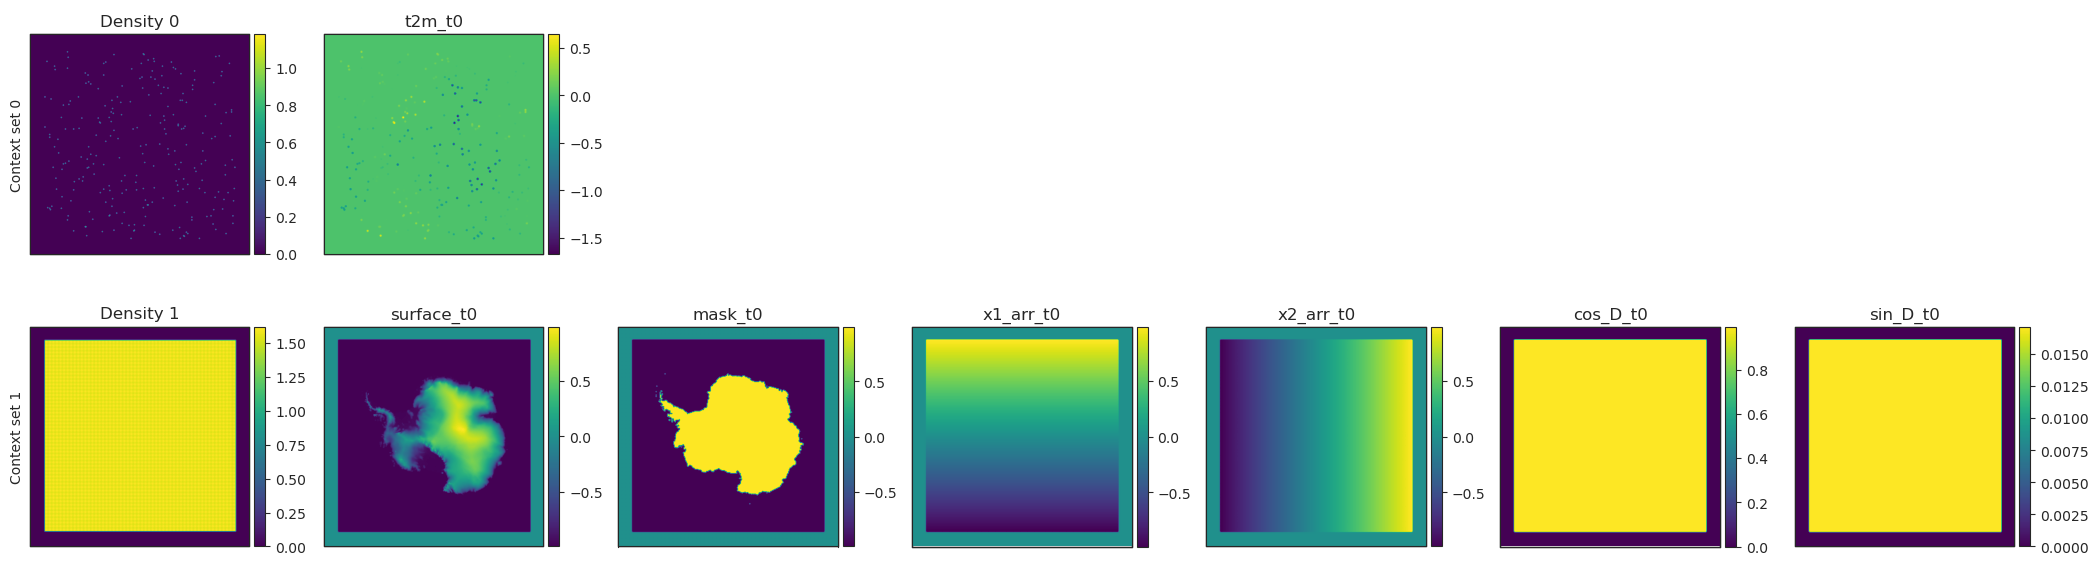

In [31]:
task = task_loader("2000-01-01", (250, "all"), 5000)
encoding = compute_encoding_tensor(model, task)
print(f"\nEncoding is shape {encoding.shape}")
fig = deepsensor.plot.context_encoding(model, task, task_loader)
plt.show()

It's a little hard to see the first encoded context set, so we can plot it separately and increase the figure size:

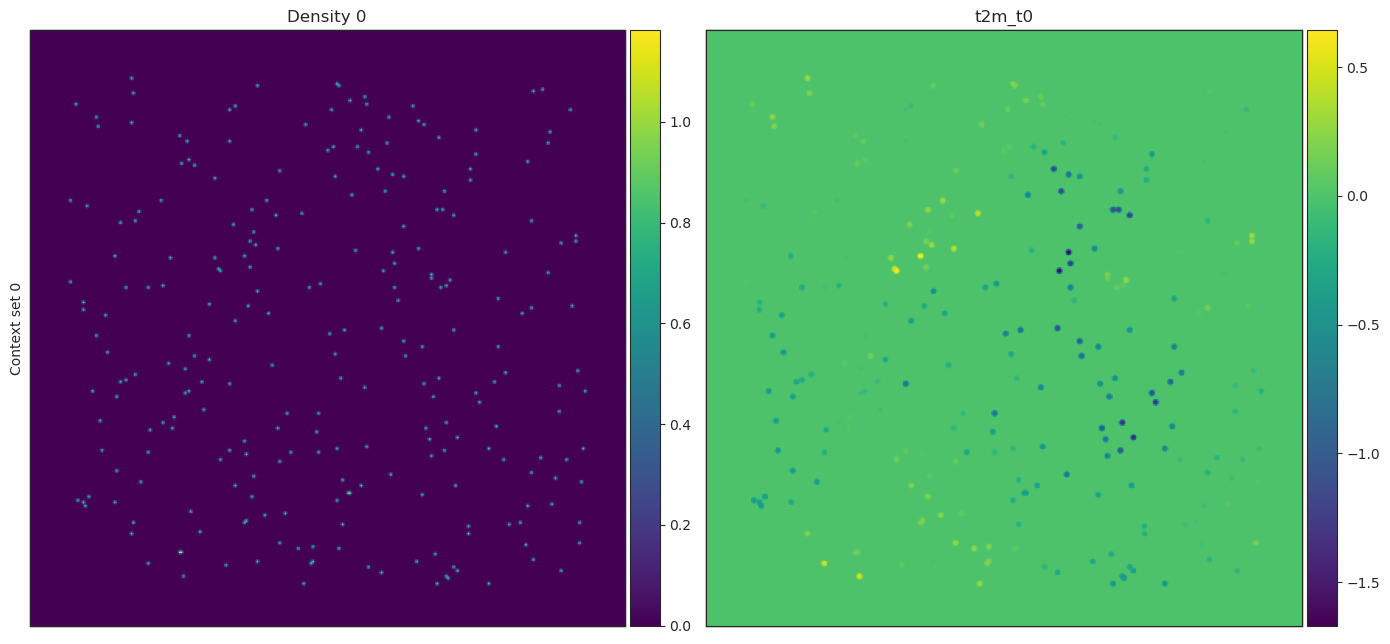

In [32]:
fig = deepsensor.plot.context_encoding(model, task, task_loader, context_set_idxs=0, size=7)
plt.show()

## Visualise the receptive field of the model

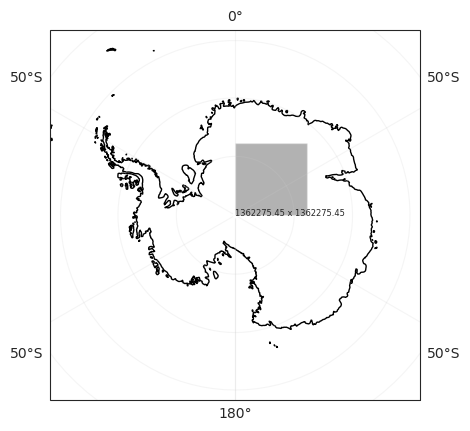

In [34]:
fig = deepsensor.plot.receptive_field(
    model.model.receptive_field, data_processor, crs, extent,
)

## Train model

The `model` attribute of a `ConvNP` object exposes the raw `neuralprocesses` model.
The model can be trained with vanilla `tensorflow` or `torch` approaches.
Here, for convenience, we will use `train_epoch`, a simple training method provided with `deepsensor`. However, you may wish to write your own training code for more flexibility.

In [ ]:
train_dates = np.random.permutation(list(pd.date_range('1980-01-01', '2009-11-30')[::100]))
train_tasks = []
for date in tqdm(train_dates):
    n_obs = np.random.randint(5, 5000)  # Random number of context observations
    train_tasks.append(task_loader(date, (n_obs, "all"), "all"))

In [ ]:
lr = 5e-5
n_epochs = 10
epoch_losses = []
for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch(model, train_tasks, lr=lr)
    epoch_loss = np.mean(batch_losses)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch} loss: {epoch_loss:.2f}")

In [ ]:
plt.plot(epoch_losses[1:])
plt.gca().set_ylabel("loss")
plt.gca().set_xlabel("epoch")

However, to save time, we will load a pre-trained model.

In [ ]:
load_weights = False
if load_weights:
    if deepsensor.backend.str == "tf":
        model.model.load_weights("../model.h5")
    elif deepsensor.backend.str == "torch":
        import torch
        model.model.load_state_dict(torch.load("../model.pt"))

## Predict on heldout data

The `ConvNP` parent class, `DeepSensorModel`, provides a `predict_ongrid` method to map from tasks to a gridded `xarray` object of predictions.

### Predicting on a regular grid

The `predict_ongrid` method receives `Task` objects containing context data and an `xr.Dataset` containing the target prediction locations.
By default the target locations are assumed to be in raw (unnormalised) form, which are more natural to work with.
However, this can be changed by setting `X_t_normalised=True`.

In [ ]:
test_date = pd.Timestamp("2014-01-01")
task = task_loader(test_date, context_sampling=(100, "all"))

In [ ]:
mean_ds, std_ds = model.predict(task, X_t=era5_raw_ds)
print(mean_ds)
print('\n')
print(std_ds)

In [ ]:
err_da = mean_ds - era5_raw_ds
err_da

In [ ]:
fig, axes = plt.subplots(subplot_kw={"projection": crs}, nrows=1, ncols=4, figsize=(20, 5))
era5_raw_ds["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[0])
axes[0].set_title("ERA5")
mean_ds["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[1])
axes[1].set_title("ConvNP mean")
std_ds["t2m"].sel(time=task["time"]).plot(cmap="Greys", ax=axes[2])
axes[2].set_title("ConvNP std dev")
err_da["t2m"].sel(time=task["time"]).plot(cmap="seismic", ax=axes[3])
axes[3].set_title("ConvNP error")
deepsensor.plot.offgrid_context(axes, task, data_processor, s=3**2, linewidths=0.5)
for ax in axes:
    ax.coastlines()

In [ ]:
mae = dask.array.fabs(err_da["t2m"]).mean()
rmse = np.sqrt(dask.array.square(err_da["t2m"]).mean())
print(f"Test MAE: {mae.values:.2f} K, RMSE: {rmse.values:.2f} K")


### Predicting at off-grid locations

Simply pass a pandas `Index` (or a `DataFrame`) containing the target locations as the `X_t` argument to `predict`.
The spatial coordinates in `X_t` will be set as the target prediction locations.
The model will return `DataFrame`s containing predictions. These will include a `'time'` index based on the `Task`s passed to the `predict` method.

Note, any indexes in `X_t` other than the spatial coordiantes will also be copied to the output `pandas` objects.
This is useful for maintaining metadata such as station names.

In [ ]:
test_dates = pd.date_range("2014-01-01", "2014-03-31")
tasks = task_loader(test_dates, (100, "all"), 0, deterministic=True)

In [ ]:
X_t = station_raw_df.loc["2014-01-01"].index  # If you pass a DataFrame, the index will be used as X_t
print(X_t)

In [ ]:
mean_df, std_df = model.predict(tasks, X_t, progress_bar=True)
print(mean_df)
print('\n')
print(std_df)

In [ ]:
plot_df = mean_df.reset_index().set_index('station').loc[['Amundsen_Scott', 'Rothera']]
# plot_df = samples_df.reset_index().set_index('station').loc[['Amundsen_Scott', 'Rothera']]

fig, ax = plt.subplots(figsize=(18, 6))
sns.lineplot(
    data=plot_df,
    x='time',
    y='t2m',
    hue='station',
    ax=ax,
)
plt.show()